
# Baseline Models for News Recommendation

This notebook implements two baseline models for news recommendation using the **MIND dataset**:

1. **Popularity-Based Recommendation**: Recommends the most-clicked news articles overall.
2. **Content-Based Filtering (TF-IDF)**: Recommends news articles similar in text (title + abstract) to a user's previously clicked articles.

In the end, we visualize the most popular news using word maps and charts.


## Merge Click Data with News Metadata

Once we have the click counts, we merge them with the news metadata to retrieve the corresponding news titles, categories, and subcategories.

### Import Libraries
This section imports the necessary libraries for data manipulation, randomization, numerical computations, and visualization using `pandas`, `numpy`, `random`, and `matplotlib`.

In [23]:

import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud


# Load dataset paths
behaviors_file = "../data/raw/MINDsmall_dev/behaviors.tsv"
news_file = "../data/raw/MINDsmall_dev/news.tsv"

# Load behaviors data
behaviors = pd.read_csv(behaviors_file, sep='\t', header=None, names=["Impression ID", "User ID", "Time", "History", "Impressions"])

# Load news data
news = pd.read_csv(news_file, sep='\t', header=None, names=["News ID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities"])


## Popularity Based Recommendation

The table below presents the most clicked news articles along with their categories and subcategories.

### Extract Clicked News IDs
Processes the `Impressions` column to extract the IDs of news articles that were clicked (`-1` suffix). This helps in identifying user interactions with news recommendations.

,News_ID,Clicks,Title,Category,SubCategory
0,N31958,8042,Opinion: Colin Kaepernick is about to get what...,sports,football_nfl
1,N36779,4688,South Carolina teen gets life in prison for de...,news,newsus
2,N5940,4191,Meghan Markle and Hillary Clinton Secretly Spe...,lifestyle,lifestyleroyals
3,N20036,3826,30 Best Black Friday Deals from Costco,lifestyle,shop-holidays
4,N23513,2900,This was uglier than a brawl. And Myles Garret...,sports,football_nfl
5,N30290,2853,The Real Reason McDonald's Keeps the Filet-O-F...,foodanddrink,restaurantsandnews
6,N58251,2536,"Some believe Mason Rudolph, hit in head with h...",sports,football_nfl
7,N24802,2247,3 Indiana judges suspended after a night of dr...,news,newsus
8,N5472,2135,Report: Police investigating woman's death aft...,sports,football_nfl
9,N53572,1826,"Taylor Swift Rep Hits Back at Big Machine, Cla...",music,musicnews


/var/folders/bb/_8p1dld53435pgwnx7msh2g80000gn/T/ipykernel_53998/1957748252.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_news_counts, y=top_news_labels, palette="Blues_r")


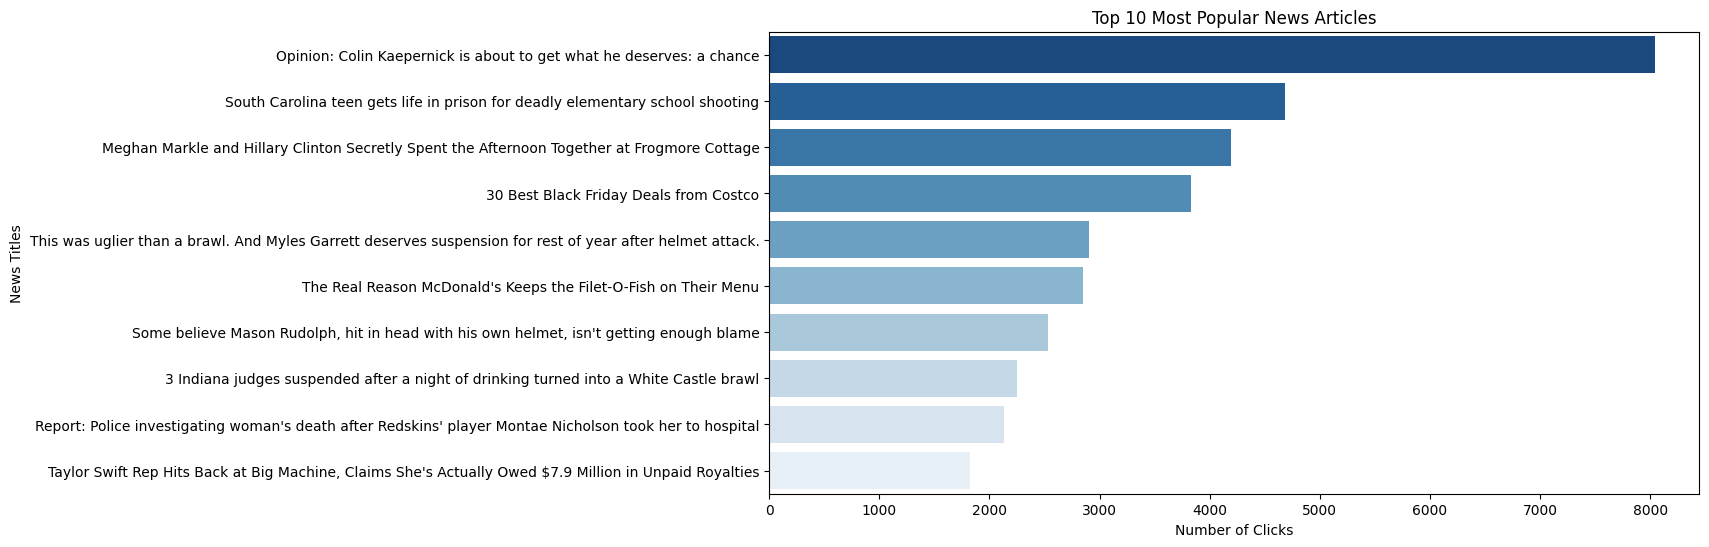

In [33]:
# Process Impressions column to extract clicked news IDs
clicked_news = []
for impression in behaviors["Impressions"].dropna():
    clicked_news += [item.split("-")[0] for item in impression.split() if item.endswith("-1")]

# Create a DataFrame for clicked news count
clicked_news_df = pd.DataFrame(clicked_news, columns=["News_ID"])
news_click_count = clicked_news_df["News_ID"].value_counts().reset_index()
news_click_count.columns = ["News_ID", "Clicks"]

# Read the news.tsv file
news_cols = ["News_ID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title_Entities", "Abstract_Entities"]
news_df = pd.read_csv(news_file, sep="\t", names=news_cols)

# Merge news click count with news information
news_clicks_merged = news_click_count.merge(news_df[["News_ID", "Title", "Category", "SubCategory"]], on="News_ID")

# Display the table
display(news_clicks_merged.head(10))

# Bar chart visualization
top_news_counts = [news_click_counts[nid] for nid in top_popular_news]
top_news_labels = [news[news["News ID"] == nid]["Title"].values[0] for nid in top_popular_news if nid in news["News ID"].values]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_news_counts, y=top_news_labels, palette="Blues_r")
plt.xlabel("Number of Clicks")
plt.ylabel("News Titles")
plt.title("Top 10 Most Popular News Articles")
plt.show()

### Count Clicks per News Article
This section iterates through the dataset and counts how many times each news article has been clicked. This will later be used to analyze engagement levels.

In [29]:

# Count clicks for each news article
news_click_counts = {}

for _, row in behaviors.iterrows():
    if pd.notna(row["Impressions"]):
        for impression in row["Impressions"].split():
            news_id, click = impression.split("-")
            if click == "1":  # Only count clicked articles
                news_click_counts[news_id] = news_click_counts.get(news_id, 0) + 1

# Get the most popular news articles
popular_news = sorted(news_click_counts.items(), key=lambda x: x[1], reverse=True)
top_popular_news = [item[0] for item in popular_news[:10]]  # Top 10 recommended articles

print(top_popular_news)


['N31958', 'N36779', 'N5940', 'N20036', 'N23513', 'N30290', 'N58251', 'N24802', 'N5472', 'N53572']


## Step 4: Generate Recommendations for content based recommendation

### Prepare Text Data and Compute TF-IDF
To create feature representations for the news articles, this section concatenates the title and abstract and then applies TF-IDF vectorization to extract meaningful numerical representations of the text.

### User History Overview


,News_ID,Title,Category,SubCategory
12,N9721,"50 Foods You Should Never Eat, According to He...",health,nutrition
1576,N22161,TobyMac says late son 'had an untamable grand ...,music,musicnews
1735,N40716,Lori Loughlin Is 'Absolutely Terrified' After ...,tv,tv-celebrity
3536,N57383,Here's Why McDonald's Keeps Bringing Back the ...,foodanddrink,foodnews
3551,N65066,12 Netflix original TV shows that critics hate...,tv,tv-gallery
5531,N35108,Applebee's Is Selling Boneless Wings For 25 Ce...,foodanddrink,foodnews
5720,N37811,Singer Lauren Alaina Has Lost 25 Lbs. on Danci...,tv,tv-celebrity
6601,N12761,"Popeyes' chicken sandwich is back on the menu,...",foodanddrink,restaurantsandnews
11816,N5663,Anti-Harry and Meghan hysteria driven by tablo...,lifestyle,lifestyleroyals
12662,N42569,Chick-fil-A is giving the entire state of Utah...,foodanddrink,foodnews



### Content-Based Recommendations


,News_ID,Title,Category,SubCategory
0,N10470,'The Little Mermaid Live!': TV Review,tv,tv-reviews
1,N22161,TobyMac says late son 'had an untamable grand ...,music,musicnews
2,N12761,"Popeyes' chicken sandwich is back on the menu,...",foodanddrink,restaurantsandnews
3,N13893,14 Weird Rules Fast-Food Employees Have to Follow,foodanddrink,restaurantsandnews
4,N8952,Chance the Rapper on 'SNL': 3 Sketches You Hav...,tv,humor
5,N63180,Taylor Swift can't shake 'Shake It Off' copyri...,music,music-celebrity
6,N22561,NFL Week 8 Power Rankings: Old-school football...,sports,football_nfl
7,N17966,Watch Jessica Biel Admit She Was NOT a 'Huge' ...,video,popculture
8,N61315,Popeyes will hire more staff to deal with retu...,finance,finance-companies
9,N59792,TobyMac's son: Christian music community mourn...,lifestyle,lifestylefamily


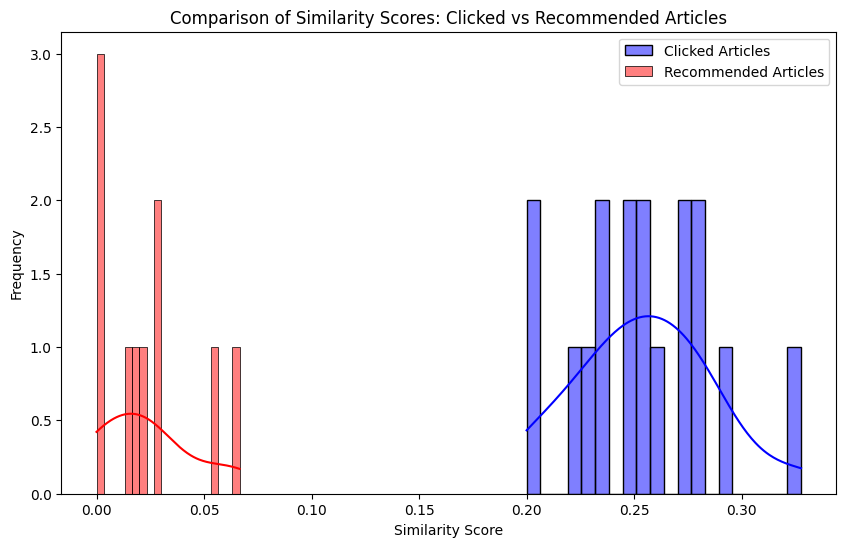

In [32]:
# Prepare text data (concatenating title and abstract)
news["Text"] = news["Title"].fillna("") + " " + news["Abstract"].fillna("")

# Compute TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
news_tfidf = vectorizer.fit_transform(news["Text"])

# Select a random user from behaviors data
random_index = random.randint(0, len(behaviors) - 1)
sample_user = behaviors.iloc[random_index]

# Extract user history
user_history = sample_user["History"].split() if pd.notna(sample_user["History"]) else []

# Display user's history to provide context for recommendations
if user_history:
    user_history_articles = news_df[news_df["News_ID"].isin(user_history)][["News_ID", "Title", "Category", "SubCategory"]]
    
    print("### User History Overview")
    display(user_history_articles.head(50))

    # Compute similarity scores between user's clicked articles and recommended articles
    clicked_indices = [news_df.index[news_df["News_ID"] == nid].tolist()[0] for nid in user_history if nid in news_df["News_ID"].values]

    if clicked_indices:
        # **Weight recent clicks higher** for user profile
        weights = np.linspace(1.0, 1.5, len(clicked_indices))  # Recent clicks get higher weight
        user_profile = np.average(news_tfidf[clicked_indices].toarray(), axis=0, weights=weights)

        # Convert to proper numpy array
        user_profile = np.asarray(user_profile).reshape(1, -1)

        # Compute similarity between user history and all news
        similarity_scores = cosine_similarity(user_profile, news_tfidf).flatten()

        # Rank articles by similarity
        ranked_indices = similarity_scores.argsort()[::-1]

        # Retrieve candidate recommended articles
        recommended_news = news_df.iloc[ranked_indices]

        # **Filter out low-similarity recommendations**
        min_similarity_threshold = 0.1  # Only keep articles above this similarity score
        recommended_news = recommended_news[similarity_scores[ranked_indices] > min_similarity_threshold]

        # **Ensure diversity by selecting articles from multiple categories**
        recommended_news = recommended_news.groupby("Category").head(2)  # Select top 2 per category
        recommended_news = recommended_news.head(10)  # Limit to 10 recommendations

        # Merge with clicks count
        recommended_news = recommended_news.merge(news_clicks_merged[["News_ID", "Clicks"]], on="News_ID", how="left").fillna(0)

        print("\n### Content-Based Recommendations")
        display(recommended_news[["News_ID", "Title", "Category", "SubCategory"]])

        # Visualization: Compare similarity between clicked and recommended articles
        clicked_similarities = similarity_scores[clicked_indices]
        recommended_similarities = similarity_scores[recommended_news.index]

        plt.figure(figsize=(10, 6))
        sns.histplot(clicked_similarities, bins=20, label="Clicked Articles", color="blue", kde=True)
        sns.histplot(recommended_similarities, bins=20, label="Recommended Articles", color="red", kde=True)
        plt.xlabel("Similarity Score")
        plt.ylabel("Frequency")
        plt.title("Comparison of Similarity Scores: Clicked vs Recommended Articles")
        plt.legend()
        plt.show()

else:
    print("No history available for this user.")



## Visualization of News

### Generate Word Cloud Visualization
A word cloud is created using the `wordcloud` library to visualize the most frequently occurring categories in the dataset. This helps in understanding the distribution of news topics.

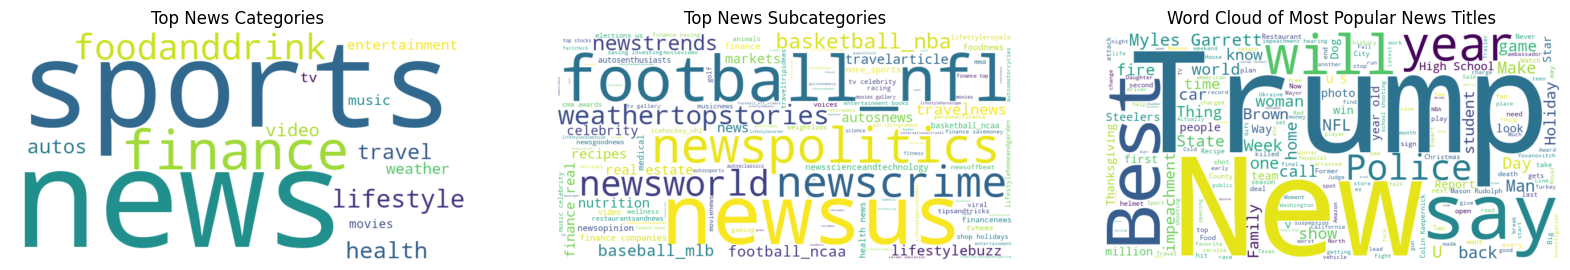

/var/folders/bb/_8p1dld53435pgwnx7msh2g80000gn/T/ipykernel_53998/2640163882.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_news_counts, y=top_news_labels, palette="Blues_r")


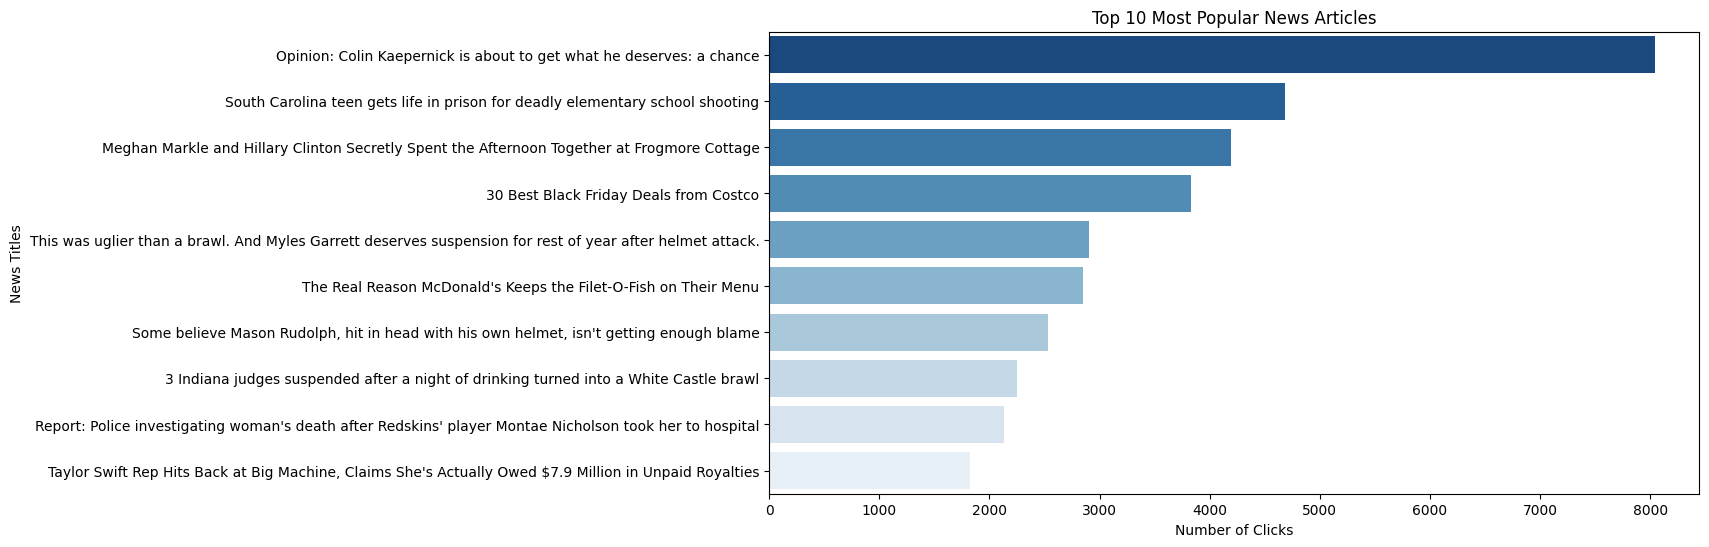

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word cloud text data
text_categories = " ".join(news_clicks_merged["Category"].dropna())
text_subcategories = " ".join(news_clicks_merged["SubCategory"].dropna())
wordcloud_text = " ".join(news_clicks_merged["Title"].dropna())

# Create a single figure with three subplots for word clouds
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Word cloud for categories
wordcloud_categories = WordCloud(width=800, height=400, background_color="white").generate(text_categories)
axes[0].imshow(wordcloud_categories, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Top News Categories")

# Word cloud for subcategories
wordcloud_subcategories = WordCloud(width=800, height=400, background_color="white").generate(text_subcategories)
axes[1].imshow(wordcloud_subcategories, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Top News Subcategories")

# Word Cloud of Popular News Titles
wordcloud_titles = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
axes[2].imshow(wordcloud_titles, interpolation="bilinear")
axes[2].axis("off")
axes[2].set_title("Word Cloud of Most Popular News Titles")

# Show the combined plot
plt.show()

